In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns

from scipy.interpolate import interp1d

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [4]:
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ'])]
df_iron_gb = df_iron[df_iron['Type'].isin(['GBRZ'])]

In [5]:
# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('Station')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
df_met = grouped_df

In [6]:
df_mobile_mud = pd.read_csv('../Dissertation_projects/Data/mobile_muds.csv', sep=',', index_col=0)

In [7]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

df_p = df_por.groupby('code').agg({
    'Stn': 'first',
    'camp': 'first'
}).reset_index()

df_p.index = df_p['code']

In [8]:
# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('code')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
grouped_df.index = grouped_df['code']
df_met = grouped_df.drop('code', axis = 1)

In [9]:
# Use combine_first to create 'Depth' column
df_iron_pw['Depth'] = df_iron_pw["Fe2_Depth"].combine_first(df_iron_pw["FeT_Depth"])
df_iron_pw['Date'] = df_iron_pw["Fe2_Date"].combine_first(df_iron_pw["FeT_Date"])

df_iron_vol = df_iron_pw.drop(columns=["Fe2_Depth","FeT_Depth","Fe2_Date","FeT_Date","Fe2_Time","FeT_Time"])
df_iron_vol['Sample_ID'] = df_iron_vol.index

df_iron_vol['Depth'] = pd.to_numeric(df_iron_vol['Depth'], errors='coerce')
df_iron_vol.loc[df_iron_vol['Depth'] <= 0, 'Depth'] = 0 
df_iron_vol['code'] = df_iron_vol['Location'] + '_' + df_iron_vol['Campaign']
codes_list = df_iron_vol['code'].unique()

df_iron_vol['Fe2_uM'].min()

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23172\987408739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iron_pw['Depth'] = df_iron_pw["Fe2_Depth"].combine_first(df_iron_pw["FeT_Depth"])
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23172\987408739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iron_pw['Date'] = df_iron_pw["Fe2_Date"].combine_first(df_iron_pw["FeT_Date"])


0.0

In [10]:
interpolated_data = []

codes_list = df_por['code'].unique()

for code in codes_list:
    data_iron = df_iron_vol[df_iron_vol['code'] == code]
    data_por = df_por[df_por['code'] == code]
    depth_fe_max = data_iron['Depth'].max()
    depth_fe_min = data_iron['Depth'].min()
    depth_po_max = data_por['depth'].max()
    depth_po_min = data_por['depth'].min()
    
    data_iron_2 = data_iron
    data_iron = data_iron.loc[data_iron['Depth'] >= depth_po_min]
    data_iron = data_iron.loc[data_iron['Depth'] <= depth_po_max] 
    
    depth = data_iron['Depth']
    depth = np.asarray(depth, dtype=float).ravel()
    fe2 = data_iron['Fe2_uM']
    fe2 = np.asarray(fe2, dtype=float).ravel()
    fe3 = data_iron['Fe3_uM']
    fe3 = np.asarray(fe3, dtype=float).ravel()
    fet = data_iron['FeT_uM']
    fet = np.asarray(fet, dtype=float).ravel()
    stn = data_iron['Location']
    camp = data_iron['Campaign']
    
    depth_p = data_por['depth']
    depth_p = np.asarray(depth_p, dtype=float).ravel()
    porosity = data_por['porosity']
    porosity = np.asarray(porosity, dtype=float).ravel()
    
    valid_indices = np.isfinite(porosity)
    porosity = porosity[valid_indices]
    depth_p = depth_p[valid_indices]
    
    cs = interp1d(depth_p, porosity)
    por_interpolated = cs(depth)
    
    interpolated_data.append(pd.DataFrame({'por_interpolated': por_interpolated,
                                           'Depth': depth,
                                           'fe2': fe2,
                                           'fe3': fe3,
                                           'fet': fet,
                                           'code': code,
                                           'stn': stn, 
                                           'camp': camp
                                          }))

interpolated_df = pd.concat(interpolated_data, ignore_index=True)
interpolated_df.dropna(subset=['Depth'], inplace=True)

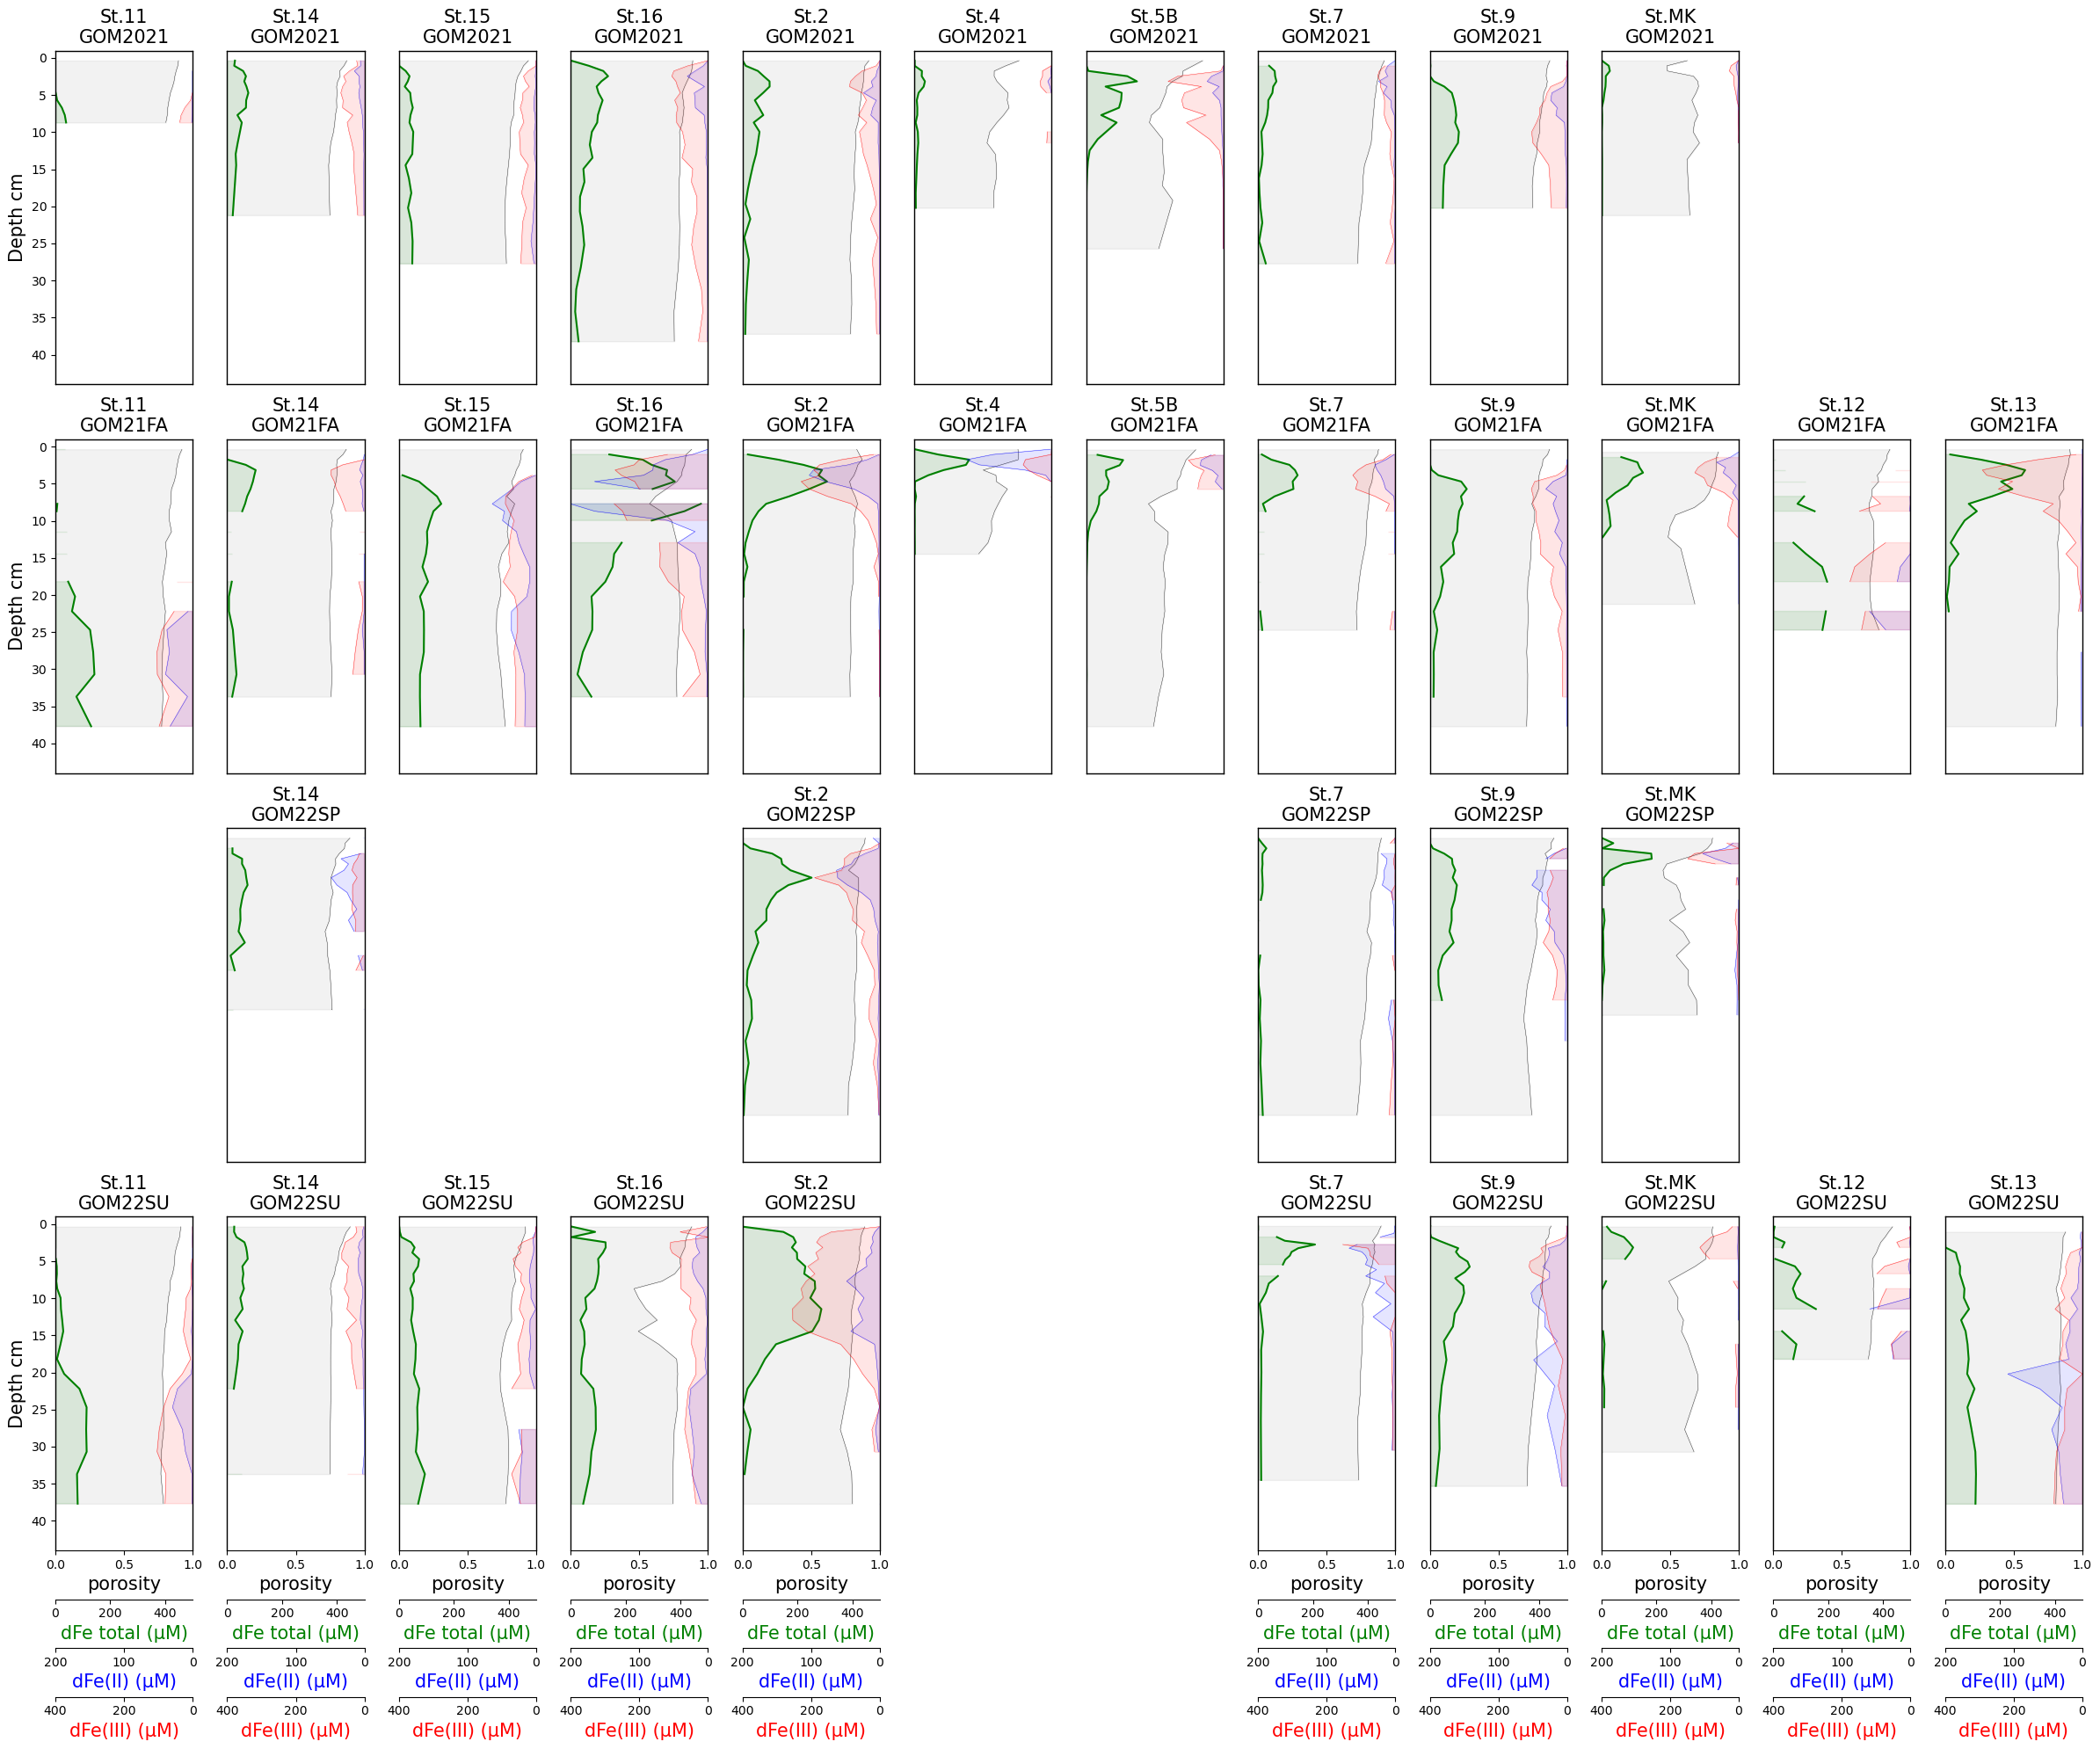

In [11]:
stations = interpolated_df['stn'].unique()
trips = interpolated_df['camp'].unique()

fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        #get data 
        data = interpolated_df[(interpolated_df['camp'] == trip) & (interpolated_df['stn'] == station)]
    
        #For Pore Waters 
        #get vars DOC 
        fe2 = data['fe2'] 
        #fe2 = np.asarray(fe2, dtype=float).ravel()
        fe3 = data['fe3'] 
        #fe3 = np.asarray(fe3, dtype=float).ravel
        fet = data['fet'] 
        #fet = np.asarray(fet, dtype=float).ravel()
        por = data['por_interpolated'] 
        #por = np.asarray(por, dtype=float).ravel()
        depth = data['Depth'] #X var 
        #depth = np.asarray(depth, dtype=float).ravel()

        if not data.empty:
            ax = axes[i, j]
            
            ax.plot(por, depth, c = 'black', lw = .25)
            ax.fill_betweenx(depth, por, color='grey', alpha=0.1)
            ax.set_title(f'{station}\n{trip}', size=15)
            ax.set_ylim(44, -1)
            ax.set_xlim(0, 1)
            
            ax2 = ax.twiny()
            ax2.plot(fet, depth, c = 'green')
            ax2.fill_betweenx(depth, fet, color='green', alpha=0.1)
            ax.set_ylim(44, -1)
            ax2.set_xlim(0, 500)
            
            ax3 = ax.twiny()
            ax3.plot(fe2, depth, c = 'blue', lw = .25)
            ax3.fill_betweenx(depth, fe2, color='blue', alpha=0.1)
            ax3.set_ylim(44, -1)
            ax3.set_xlim(200, 0)
            
            ax4 = ax.twiny()
            ax4.plot(fe3, depth, c = 'red', lw = .25)
            ax4.fill_betweenx(depth, fe3, color='red', alpha=0.1)
            ax4.set_ylim(44, -1)
            ax4.set_xlim(400, 0)
        
        else: 
            axes[i, j].axis('off')  
        if j == 0:
            axes[i,j].set_ylabel('Depth cm', size=15, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
            ax.set_yticks([])
        
        if i == 3:
            ax.set_xlabel('porosity', size=15, c='black')
            ax.xaxis.set_tick_params(labelsize=10)
            
            ax2.set_xlabel('dFe total (\u03BCM)', size = 15, c= 'green')
            ax2.xaxis.set_ticks_position('bottom')
            ax2.xaxis.set_label_position('bottom')
            ax2.spines['bottom'].set_position(('outward', 40))
            
            ax3.set_xlabel('dFe(II) (\u03BCM)', size = 15, c= 'blue')
            ax3.xaxis.set_ticks_position('bottom')
            ax3.xaxis.set_label_position('bottom')
            ax3.spines['bottom'].set_position(('outward', 80))
            
            ax4.set_xlabel('dFe(III) (\u03BCM)', size = 15, c= 'red')
            ax4.xaxis.set_ticks_position('bottom')
            ax4.xaxis.set_label_position('bottom')
            ax4.spines['bottom'].set_position(('outward', 120))
            
        else: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])
            
            ax2.set_xlabel('')
            ax2.xaxis.set_ticklabels([])
            ax2.set_xticks([])
            
            ax3.set_xlabel('')
            ax3.xaxis.set_ticklabels([])
            ax3.set_xticks([])
            
            ax4.set_xlabel('')
            ax4.xaxis.set_ticklabels([])
            ax4.set_xticks([])
            
            
plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/profile_carbon.png')
plt.show()


In [12]:
df_cal = interpolated_df
df_cal['sed_density_Gpercm3'] = 2.6

#fe uM to M 
df_cal['fe2_mol_per_m3'] =  df_cal['fe2'] / 1000000 * 1000
df_cal['fe3_mol_per_m3'] =  df_cal['fe3'] / 1000000 * 1000
df_cal['fet_mol_per_m3'] =  df_cal['fet'] / 1000000 * 1000

df_cal['fe2_mol_per_m3_vol'] =  df_cal['fe2_mol_per_m3'] * df_cal['por_interpolated']
df_cal['fe3_mol_per_m3_vol'] =  df_cal['fe3_mol_per_m3'] * df_cal['por_interpolated']
df_cal['fet_mol_per_m3_vol'] =  df_cal['fet_mol_per_m3'] * df_cal['por_interpolated']

df_cal['depth_m'] = df_cal['Depth'] / 100

df_cal

por_interpolated  Depth    fe2       fe3       fet           code    stn  \
0            0.897196   0.35  0.145       NaN       NaN  St.11_GOM2021  St.11   
1            0.891846   1.05    NaN       NaN       NaN  St.11_GOM2021  St.11   
2            0.879845   1.75  0.145       NaN       NaN  St.11_GOM2021  St.11   
3            0.870578   2.45  0.145       NaN       NaN  St.11_GOM2021  St.11   
4            0.864441   3.15  0.145       NaN       NaN  St.11_GOM2021  St.11   
..                ...    ...    ...       ...       ...            ...    ...   
779          0.699232  20.20  0.379  4.384347  4.763347  St.MK_GOM22SU  St.MK   
780          0.704056  22.20  0.699  9.290839  9.989839  St.MK_GOM22SU  St.MK   
781          0.659089  24.70  0.677  8.786629  9.463629  St.MK_GOM22SU  St.MK   
782          0.605461  27.70  1.032       NaN       NaN  St.MK_GOM22SU  St.MK   
783          0.673309  30.70    NaN       NaN  3.849622  St.MK_GOM22SU  St.MK   

        camp  sed_density_Gpercm3  fe2_mol_per_m3  fe3_mol_per_m3  \
0    GOM2021                  2.6        0.000145             NaN   
1    GOM2021                  2.6             NaN             NaN   
2    GOM2021                  2.6        0.000145             NaN   
3    GOM2021                  2.6        0.000145             NaN   
4    GOM2021                  2.6        0.000145             NaN   
..       ...                  ...             ...             ...   
779  GOM22SU                  2.6        0.000379        0.004384   
780  GOM22SU                  2.6        0.000699        0.009291   
781  GOM22SU                  2.6        0.000677        0.008787   
782  GOM22SU                  2.6        0.001032             NaN   
783  GOM22SU                  2.6             NaN             NaN   

     fet_mol_per_m3  fe2_mol_per_m3_vol  fe3_mol_per_m3_vol  \
0               NaN            0.000130                 NaN   
1               NaN                 NaN                 NaN   
2               NaN            0.000128                 NaN   
3               NaN            0.000126                 NaN   
4               NaN            0.000125                 NaN   
..              ...                 ...                 ...   
779        0.004763            0.000265            0.003066   
780        0.009990            0.000492            0.006541   
781        0.009464            0.000446            0.005791   
782             NaN            0.000625                 NaN   
783        0.003850                 NaN                 NaN   

     fet_mol_per_m3_vol  depth_m  
0                   NaN   0.0035  
1                   NaN   0.0105  
2                   NaN   0.0175  
3                   NaN   0.0245  
4                   NaN   0.0315  
..                  ...      ...  
779            0.003331   0.2020  
780            0.007033   0.2220  
781            0.006237   0.2470  
782                 NaN   0.2770  
783            0.002592   0.3070  

[784 rows x 16 columns]

In [13]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['fet_mol_per_m3_vol'] = 0 
    new_row['fe2_mol_per_m3_vol'] = 0 
    new_row['fe3_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'fet_mol_per_m3_vol'])
    ds_fe3 = df_play.dropna(subset=['depth_m', 'fe3_mol_per_m3_vol'])
    ds_fe2 = df_play.dropna(subset=['depth_m', 'fe2_mol_per_m3_vol'])


    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .05

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['fet_mol_per_m3_vol'])
    fe3_at_depth_5 = np.interp(stop_depth, ds_fe3['depth_m'], ds_fe3['fe3_mol_per_m3_vol'])
    fe2_at_depth_5 = np.interp(stop_depth, ds_fe2['depth_m'], ds_fe2['fe2_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['fet_mol_per_m3_vol'] = fet_at_depth_5
    new_row['fe3_mol_per_m3_vol'] = fe3_at_depth_5
    new_row['fe2_mol_per_m3_vol'] = fe2_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])

    selected_data_fe3 = ds_fe3[(ds_fe3['depth_m'] >= start_depth) & (ds_fe3['depth_m'] <= stop_depth)]
    selected_data_fe3 = pd.concat([selected_data_fe3, new_row])

    selected_data_fe2 = ds_fe2[(ds_fe2['depth_m'] >= start_depth) & (ds_fe2['depth_m'] <= stop_depth)]
    selected_data_fe2 = pd.concat([selected_data_fe2, new_row])

    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['fet_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth
    integral_fe3 = np.trapz(selected_data_fe3['fe3_mol_per_m3_vol'], selected_data_fe3['depth_m']) / stop_depth
    integral_fe2 = np.trapz(selected_data_fe2['fe2_mol_per_m3_vol'], selected_data_fe2['depth_m']) / stop_depth

    dic = {'code':[code],
           'fet_mol_per_m3_0_to_5cm':[integral_fet],
           'fe3_mol_per_m3_0_to_5cm':[integral_fe3], 
           'fe2_mol_per_m3_0_to_5cm':[integral_fe2]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_fe_5 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_fe_5

fet_mol_per_m3_0_to_5cm  fe3_mol_per_m3_0_to_5cm  \
code                                                              
St.11_GOM2021                 0.000460                 0.000395   
St.14_GOM2021                 0.044729                 0.038293   
St.15_GOM2021                 0.019401                 0.018704   
St.16_GOM2021                 0.076588                 0.064643   
St.2_GOM2021                  0.052417                 0.045372   
St.4_GOM2021                  0.012621                 0.011734   
St.5B_GOM2021                 0.049136                 0.043472   
St.7_GOM2021                  0.043682                 0.032189   
St.9_GOM2021                  0.018908                 0.015226   
St.MK_GOM2021                 0.009311                 0.008401   
St.11_GOM21FA                 0.006597                 0.004970   
St.12_GOM21FA                 0.032325                 0.035657   
St.13_GOM21FA                 0.147204                 0.147142   
St.14_GOM21FA                 0.042565                 0.040053   
St.15_GOM21FA                 0.014082                 0.010891   
St.16_GOM21FA                 0.210581                 0.151873   
St.2_GOM21FA                  0.147576                 0.106934   
St.4_GOM21FA                  0.059305                 0.024189   
St.5B_GOM21FA                 0.053712                 0.041175   
St.7_GOM21FA                  0.071435                 0.058260   
St.9_GOM21FA                  0.018250                 0.015615   
St.MK_GOM21FA                 0.082396                 0.069563   
St.14_GOM22SP                 0.025782                 0.013291   
St.2_GOM22SP                  0.071562                 0.051869   
St.4 _GOM22SP                 0.000000                 0.000000   
St.7_GOM22SP                  0.013696                 0.003664   
St.9_GOM22SP                  0.039707                 0.024773   
St.MK_GOM22SP                 0.046396                 0.037743   
St.11_GOM22SU                 0.000329                 0.000280   
St.12_GOM22SU                 0.012116                 0.011645   
St.13_GOM22SU                 0.010876                 0.009784   
St.14_GOM22SU                 0.042589                 0.038168   
St.15_GOM22SU                 0.029590                 0.026595   
St.16_GOM22SU                 0.067272                 0.058031   
St.2_GOM22SU                  0.136271                 0.127360   
St.4 _GOM22SU                 0.000000                 0.000000   
St.5b_GOM22SU                 0.000000                 0.000000   
St.7_GOM22SU                  0.075728                 0.051682   
St.9_GOM22SU                  0.045686                 0.035357   
St.MK_GOM22SU                 0.060336                 0.059315   

               fe2_mol_per_m3_0_to_5cm  
code                                    
St.11_GOM2021                 0.000123  
St.14_GOM2021                 0.006435  
St.15_GOM2021                 0.000697  
St.16_GOM2021                 0.011944  
St.2_GOM2021                  0.007045  
St.4_GOM2021                  0.000871  
St.5B_GOM2021                 0.005664  
St.7_GOM2021                  0.011174  
St.9_GOM2021                  0.003682  
St.MK_GOM2021                 0.000911  
St.11_GOM21FA                 0.000018  
St.12_GOM21FA                 0.000351  
St.13_GOM21FA                 0.000067  
St.14_GOM21FA                 0.002386  
St.15_GOM21FA                 0.003191  
St.16_GOM21FA                 0.058054  
St.2_GOM21FA                  0.040642  
St.4_GOM21FA                  0.035143  
St.5B_GOM21FA                 0.012537  
St.7_GOM21FA                  0.013175  
St.9_GOM21FA                  0.002640  
St.MK_GOM21FA                 0.012133  
St.14_GOM22SP                 0.011548  
St.2_GOM22SP                  0.020577  
St.4 _GOM22SP                 0.000000  
St.7_GOM22SP                  0.009057  
St.9_GOM22SP                  0.016359  
St.MK_GOM22

In [14]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['fet_mol_per_m3_vol'] = 0 
    new_row['fe2_mol_per_m3_vol'] = 0 
    new_row['fe3_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'fet_mol_per_m3_vol'])
    ds_fe3 = df_play.dropna(subset=['depth_m', 'fe3_mol_per_m3_vol'])
    ds_fe2 = df_play.dropna(subset=['depth_m', 'fe2_mol_per_m3_vol'])


    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .25

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['fet_mol_per_m3_vol'])
    fe3_at_depth_5 = np.interp(stop_depth, ds_fe3['depth_m'], ds_fe3['fe3_mol_per_m3_vol'])
    fe2_at_depth_5 = np.interp(stop_depth, ds_fe2['depth_m'], ds_fe2['fe2_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['fet_mol_per_m3_vol'] = fet_at_depth_5
    new_row['fe3_mol_per_m3_vol'] = fe3_at_depth_5
    new_row['fe2_mol_per_m3_vol'] = fe2_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])

    selected_data_fe3 = ds_fe3[(ds_fe3['depth_m'] >= start_depth) & (ds_fe3['depth_m'] <= stop_depth)]
    selected_data_fe3 = pd.concat([selected_data_fe3, new_row])

    selected_data_fe2 = ds_fe2[(ds_fe2['depth_m'] >= start_depth) & (ds_fe2['depth_m'] <= stop_depth)]
    selected_data_fe2 = pd.concat([selected_data_fe2, new_row])

    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['fet_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth
    integral_fe3 = np.trapz(selected_data_fe3['fe3_mol_per_m3_vol'], selected_data_fe3['depth_m']) / stop_depth
    integral_fe2 = np.trapz(selected_data_fe2['fe2_mol_per_m3_vol'], selected_data_fe2['depth_m']) / stop_depth

    dic = {'code':[code],
           'fet_mol_per_m3_0_to_25cm':[integral_fet],
           'fe3_mol_per_m3_0_to_25cm':[integral_fe3], 
           'fe2_mol_per_m3_0_to_25cm':[integral_fe2]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_fe_25 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_fe_25

fet_mol_per_m3_0_to_25cm  fe3_mol_per_m3_0_to_25cm  \
code                                                                
St.11_GOM2021                  0.023253                  0.022484   
St.14_GOM2021                  0.030305                  0.027952   
St.15_GOM2021                  0.030869                  0.028864   
St.16_GOM2021                  0.055809                  0.050931   
St.2_GOM2021                   0.034416                  0.031250   
St.4_GOM2021                   0.006348                  0.008427   
St.5B_GOM2021                  0.022840                  0.021003   
St.7_GOM2021                   0.018852                  0.015575   
St.9_GOM2021                   0.046517                  0.043031   
St.MK_GOM2021                  0.002708                  0.002267   
St.11_GOM21FA                  0.030112                  0.026051   
St.12_GOM21FA                  0.091530                  0.082279   
St.13_GOM21FA                  0.064880                  0.063909   
St.14_GOM21FA                  0.025305                  0.024207   
St.15_GOM21FA                  0.065777                  0.046997   
St.16_GOM21FA                  0.156110                  0.117548   
St.2_GOM21FA                   0.055416                  0.044264   
St.4_GOM21FA                   0.012461                  0.007206   
St.5B_GOM21FA                  0.017152                  0.047689   
St.7_GOM21FA                   0.030467                  0.027633   
St.9_GOM21FA                   0.045416                  0.039804   
St.MK_GOM21FA                  0.024264                  0.021143   
St.14_GOM22SP                  0.028790                  0.017244   
St.2_GOM22SP                   0.059835                  0.048776   
St.4 _GOM22SP                  0.000000                  0.000000   
St.7_GOM22SP                   0.007922                  0.003234   
St.9_GOM22SP                   0.046617                  0.032722   
St.MK_GOM22SP                  0.012344                  0.009739   
St.11_GOM22SU                  0.020527                  0.017170   
St.12_GOM22SU                  0.048098                  0.036716   
St.13_GOM22SU                  0.053631                  0.035077   
St.14_GOM22SU                  0.034711                  0.031603   
St.15_GOM22SU                  0.041748                  0.036396   
St.16_GOM22SU                  0.048197                  0.040325   
St.2_GOM22SU                   0.130224                  0.116628   
St.4 _GOM22SU                  0.000000                  0.000000   
St.5b_GOM22SU                  0.000000                  0.000000   
St.7_GOM22SU                   0.030128                  0.017854   
St.9_GOM22SU                   0.059246                  0.036768   
St.MK_GOM22SU                  0.018765                  0.018608   

               fe2_mol_per_m3_0_to_25cm  
code                                     
St.11_GOM2021                  0.000780  
St.14_GOM2021                  0.002353  
St.15_GOM2021                  0.002005  
St.16_GOM2021                  0.004878  
St.2_GOM2021                   0.003166  
St.4_GOM2021                   0.000255  
St.5B_GOM2021                  0.001837  
St.7_GOM2021                   0.003214  
St.9_GOM2021                   0.003485  
St.MK_GOM2021                  0.000389  
St.11_GOM21FA                  0.002573  
St.12_GOM21FA                  0.009987  
St.13_GOM21FA                  0.000977  
St.14_GOM21FA                  0.001075  
St.15_GOM21FA                  0.018780  
St.16_GOM21FA                  0.036972  
St.2_GOM21FA                   0.011180  
St.4_GOM21FA                   0.007660  
St.5B_GOM21FA                  0.003681  
St.7_GOM21FA                   0.003581  
St.9_GOM21FA                   0.005614  
St.MK_GOM21FA                  0.002940  
St.14_GOM22SP                  0.010398  
St.2_GOM22SP                   0.011236  
St.4 _GOM22SP           

In [15]:
stocks_pw_fe = pd.concat([stocks_pw_fe_25, stocks_pw_fe_5], axis=1)
stocks_pw_fe.to_csv('../Dissertation_projects/Data/Stats_data_sets/Iron_stocks.csv')
stocks_pw_fe

fet_mol_per_m3_0_to_25cm  fe3_mol_per_m3_0_to_25cm  \
code                                                                
St.11_GOM2021                  0.023253                  0.022484   
St.14_GOM2021                  0.030305                  0.027952   
St.15_GOM2021                  0.030869                  0.028864   
St.16_GOM2021                  0.055809                  0.050931   
St.2_GOM2021                   0.034416                  0.031250   
St.4_GOM2021                   0.006348                  0.008427   
St.5B_GOM2021                  0.022840                  0.021003   
St.7_GOM2021                   0.018852                  0.015575   
St.9_GOM2021                   0.046517                  0.043031   
St.MK_GOM2021                  0.002708                  0.002267   
St.11_GOM21FA                  0.030112                  0.026051   
St.12_GOM21FA                  0.091530                  0.082279   
St.13_GOM21FA                  0.064880                  0.063909   
St.14_GOM21FA                  0.025305                  0.024207   
St.15_GOM21FA                  0.065777                  0.046997   
St.16_GOM21FA                  0.156110                  0.117548   
St.2_GOM21FA                   0.055416                  0.044264   
St.4_GOM21FA                   0.012461                  0.007206   
St.5B_GOM21FA                  0.017152                  0.047689   
St.7_GOM21FA                   0.030467                  0.027633   
St.9_GOM21FA                   0.045416                  0.039804   
St.MK_GOM21FA                  0.024264                  0.021143   
St.14_GOM22SP                  0.028790                  0.017244   
St.2_GOM22SP                   0.059835                  0.048776   
St.4 _GOM22SP                  0.000000                  0.000000   
St.7_GOM22SP                   0.007922                  0.003234   
St.9_GOM22SP                   0.046617                  0.032722   
St.MK_GOM22SP                  0.012344                  0.009739   
St.11_GOM22SU                  0.020527                  0.017170   
St.12_GOM22SU                  0.048098                  0.036716   
St.13_GOM22SU                  0.053631                  0.035077   
St.14_GOM22SU                  0.034711                  0.031603   
St.15_GOM22SU                  0.041748                  0.036396   
St.16_GOM22SU                  0.048197                  0.040325   
St.2_GOM22SU                   0.130224                  0.116628   
St.4 _GOM22SU                  0.000000                  0.000000   
St.5b_GOM22SU                  0.000000                  0.000000   
St.7_GOM22SU                   0.030128                  0.017854   
St.9_GOM22SU                   0.059246                  0.036768   
St.MK_GOM22SU                  0.018765                  0.018608   

               fe2_mol_per_m3_0_to_25cm  fet_mol_per_m3_0_to_5cm  \
code                                                               
St.11_GOM2021                  0.000780                 0.000460   
St.14_GOM2021                  0.002353                 0.044729   
St.15_GOM2021                  0.002005                 0.019401   
St.16_GOM2021                  0.004878                 0.076588   
St.2_GOM2021                   0.003166                 0.052417   
St.4_GOM2021                   0.000255                 0.012621   
St.5B_GOM2021                  0.001837                 0.049136   
St.7_GOM2021                   0.003214                 0.043682   
St.9_GOM2021                   0.003485                 0.018908   
St.MK_GOM2021                  0.000389                 0.009311   
St.11_GOM21FA                  0.002573                 0.006597   
St.12_GOM21FA                  0.009987                 0.032325   
St.13_GOM21FA                  0.000977                 0.147204   
St.14_GOM21FA                  0.001075                 0.042565   
St.15_GOM21FA               